## Setup
The utilities.py has most of the content of the algorithms.

In [63]:
from pathlib import Path
import utilities as util
current_score = [0,0]
model_score = [0,0]

## Load the cloud dataset

I chose to solely use the [CCSN dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CADDPD) because it had consistent, labeled ground images of clouds. There were many more labeled datasets that used satellite imagery but the point was to create a algorithm that a person can use to identify cloud type using an image they took from the ground. Some other datasets had labels that were too broad such as using [texture](http://vintage.winklerbros.net/swimcat.html) or data that was publically [unavailable](https://journals.ametsoc.org/view/journals/atot/31/1/jtech-d-13-00048_1.xml).



In [2]:
data_dir = Path('./data/CCSN-dataset')
list_ds, image_count = util.load_data(data_dir)

there are 2543 images



## Summary of data
The CCSN dataset contains color images 400x400 pixels.

with 11 different classes
 ['Ac' 'As' 'Cb' 'Cc' 'Ci' 'Cs' 'Ct' 'Cu' 'Ns' 'Sc' 'St'] 



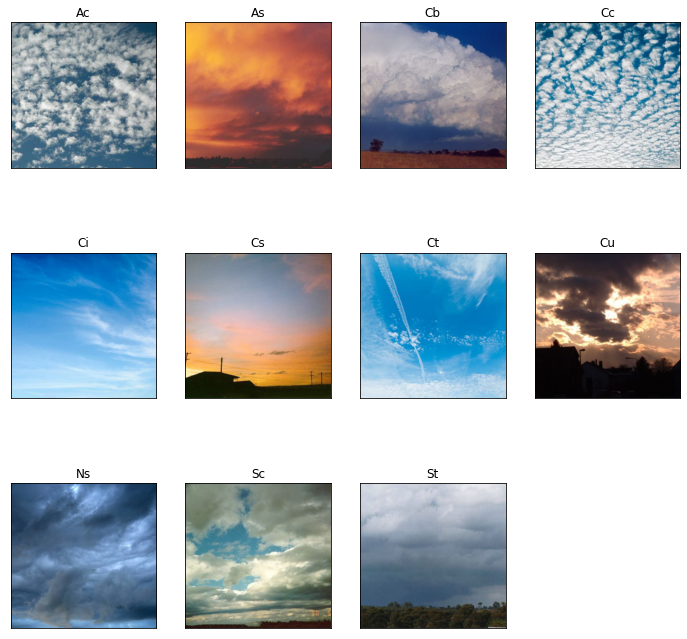

In [3]:
util.get_class_names(data_dir)
util.plot_ex_images(data_dir)

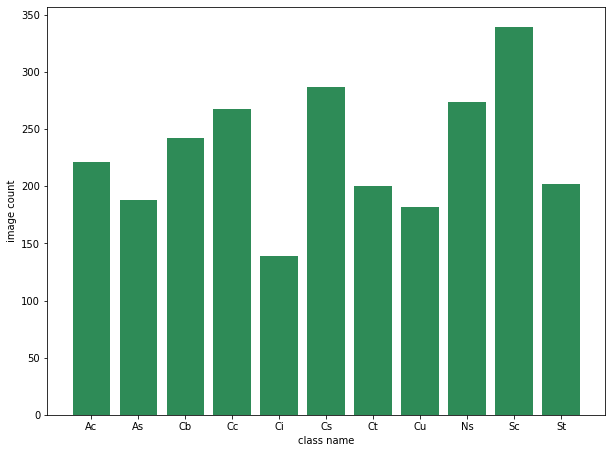

In [4]:
util.label_histogram(data_dir)

In [5]:
util.info_table()

## Data allocation
20 percent of the data is used for validation

In [6]:
# allocate data for training and for validation
train_ds, val_ds = util.allocate_data(list_ds, image_count)

2035 images are used for training
508 images are used for validation


## Preprocess the data and configure for performance

1. from file path, load raw data from *jpg files as a string
2. convert from string to 3D uint8 tensor
3. ensure that the size of image is correct
4. correlate label to image data
5. create the performance model that tracks time spent in each operation and feeds that to the optimization algorithm
6. allocate the CPU budget across all tunable operations


In [7]:
# set up parallel processing and performance
train_ds, val_ds = util.configuration(train_ds, val_ds)

## Image Augmentation

To combat overfitting due to scarcity of data, we can implement data augmentation. The addition of augmented images will increase the diversity of the training set by applying random, yet realistic, transformations. For this algorithm, I randomly applied horizontal **flip**, **rotation** +-10% and **zoom** +-20%. I chose not flip the images vertically so that the ground will stay with the bottom half of the image.

The first image shows the unaugmented input from the training dataset.

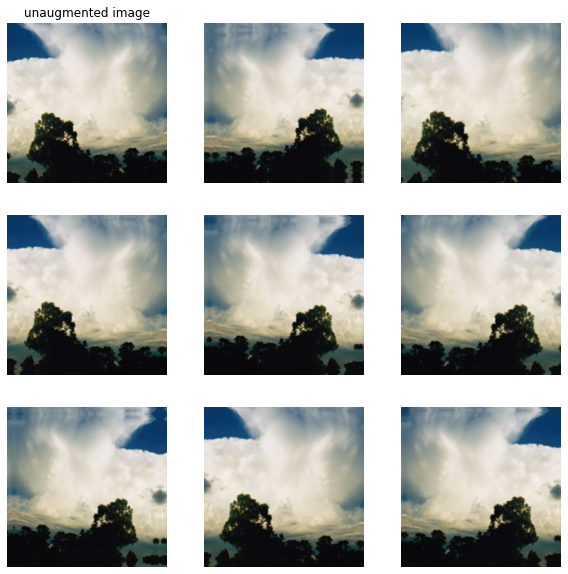

In [8]:
model = util.data_aug(train_ds)

## Build the model 
### 1. Set up the layers
The layers extract representations from the data fed into them.
- The <b>Conv2D</b> specifies the 2D convolutional layer. The convoluational layers in the neural network summarize the presence of features for an input image.
- <b>Max Pooling</b> layers reduces the sensitivity the output feature map has on the location of the features. MaxPooling2D calculates the maximum value in each patch of the feature map. Max Pooling has been [shown](http://silverio.net.br/heitor/disciplinas/eeica/papers/Livros/[Chollet]-Deep_Learning_with_Python.pdf) to work better than average pooling for image classification tasks.
- The <b>Dropout</b> layers randomly select a percentage of neurons to be set to 0. This prevents overfitting by other neurons having to independently pick up the dropped neuron's representation, resulting in multiple neurons being needed to confirm a given feature.
- The <b>Flatten</b> layer reduces dimensionality to a one dimensional array.
- The <b>Dense</b> layer is fully connected NN layer with a specified number of neurons and type of element-wise activation function.


### 2. Compile the model
The compile step will specify the optimizer, loss function and metrics. 
- The <b>optimizer</b> will update the weights of the network based on the results of the loss function. I chose to use the adam optimizer, it is commonly used in deep learning applications, especially in image classification. 
- The <b>loss function</b> evaluates how well the model is predicting the classes of the images. I chose sparse categorical cross entropy because this is a multi-class classification problem and my classes are mutually exclusive (I want one class per image).
- The <b>loss function</b> monitors the performance of the training and validation process. I used  the accuracy metric which will give the fraction of the images that are correctly classified.

In [9]:
model = util.build_base_model_dropout(model)

### Train the model

model.fit() will train the model by dividing the data into batches of a specified size and iterating over the entire dataset for a given number of epochs. 

would you like to save your model? [y/n]: y


2021-02-02 19:51:13.384 | INFO     | utilities_test:fit_model:251 - Start training
2021-02-03 11:33:03.488 | INFO     | utilities_test:fit_model:260 - Elapsed time (s): 56510.102461099625


INFO:tensorflow:Assets written to: cloud_model_500/assets


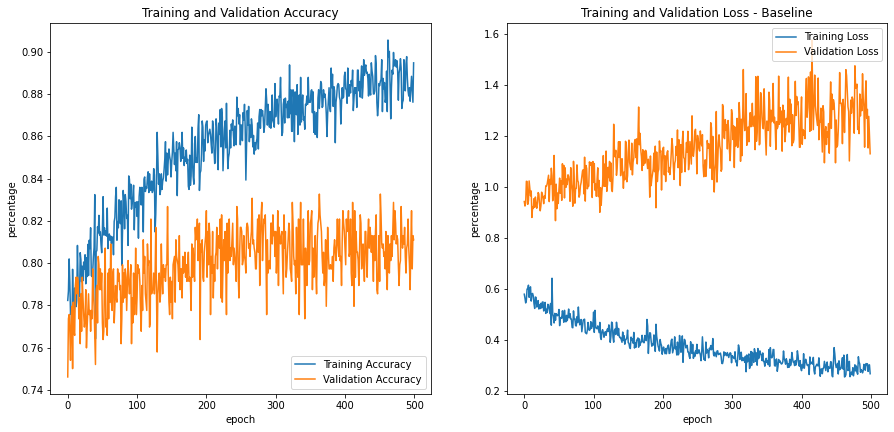

In [13]:
num_epochs = 500
history, model = util.fit_model(train_ds, val_ds, model, num_epochs)
util.plot_results(history, num_epochs)

In [14]:
print('final validation accuracy is: ' + str(round(history.history['val_accuracy'][-1]*100, 1)) + '%')

final validation accuracy is: 81.1%


### Load existing model
If you don't want to run a model, you can load a pre-existing model!

In [15]:
import utilities_test as util

loaded_model = util.load_existing_model()
if loaded_model != None:
    model = loaded_model

would you like to load a saved model? [y/n] n
using existing model


### Test your model/yourself

Run the next cell for you to be able to compare yourself with your model and the "correct" answer!

As


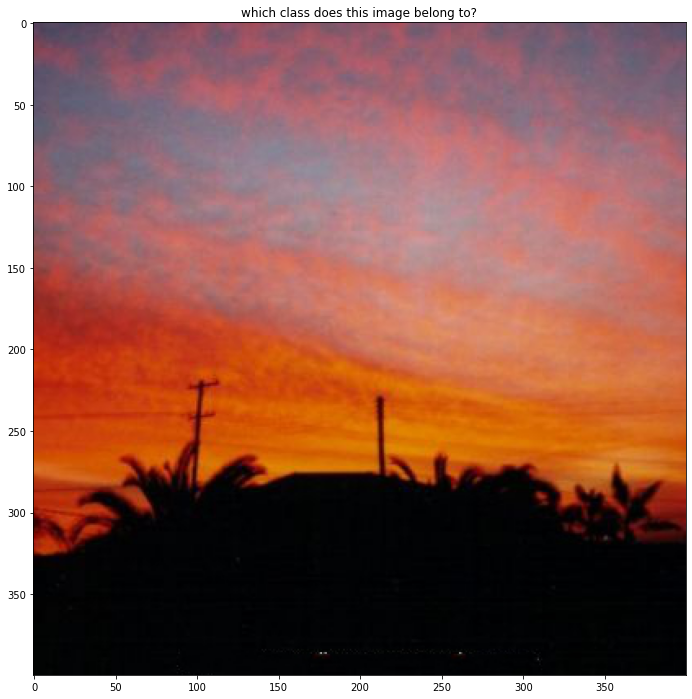

define the class: Ac
not quite
correct answer:  As
The model predicts that these clouds are: As

your current score is:  0.75
the models score is:  0.7916666666666666


In [62]:
current_score, model_score = util.compare_yourself(data_dir, current_score, model_score, model)

Use the table to help you classify your clouds!

In [17]:
util.info_table()

## Conclusions

I had fun exploring many of the machine learning tools keras/tensorflow has to offer for image classification. I learned A LOT more than I would from reading any one partiular paper, but it also took A LOT more time. Most of my efforts were spent trying to expand the database and work with the issues of overfitting.

One thing I explored, but would like to dig deeper into, was scraping images from the internet to increase the database. The World Meteorlogical Organization (WMO) has a [database](https://cloudatlas.wmo.int/en/search-image-gallery.html) that has all the cloud types neatly organized. I initially wanted to scrape their database, but hit a wall when I found out that if you open the image in a new tab to get the full size, you get the image metadata txt file. 

Next, I looked into scraping Google Images. I created an algorithm using [selenium](https://selenium-python.readthedocs.io/getting-started.html) to click on each image and save it at its full resolution. This had a lot of issues, most of which I worked through. I ran into issues with scrolling to get new images being finicky. Sometimes, the search parameter would change, I think the clicker was clicking on a related image instead of the one I expected. So I'd be in a google search for 'cumulus clouds' and then I'd be in a search for 'cirrus clouds'. I added a catch that will go back to the previous page if the cloud type is not contained within the search. The issue with that is when the page went from 'cumulus clouds' to 'cirrus stratus cumulus clouds'. This would should be an easy fix.

I also looked into methods to reduce overfitting while not increasing the input database. The first method I explored was implementing [dropout layers](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). A dropout layer will randomly zero-out a percentage of neurons, forcing the neural network to learn more robust features.

Another overfitting preventative measure was to augment the images to artificially increase the database. There were three transformations I applied, flipping, rotation and zooming. My results were worse after the addition of the augmented images. Overall, most cloud types can be transformed into looking like another cloud type. I think this would be more beneficial in a classification problem with more distinct classes.

After digging into the CCSN dataset, there were definitely some poorly classified images as seen in the next cell. There were instances of the image being misclassified, images that were generally poor and at least one instance of an image being put into multiple classes.

One thing that was not covered in this notebook but I spent a lot of time working with, is hyperparameter tuning with keras. You give the tuner a search space for building a model and it will give you the optimal model. This seems almost too good to be true (I never got it to work, so maybe it is). I'd love to dig into this a bit further.


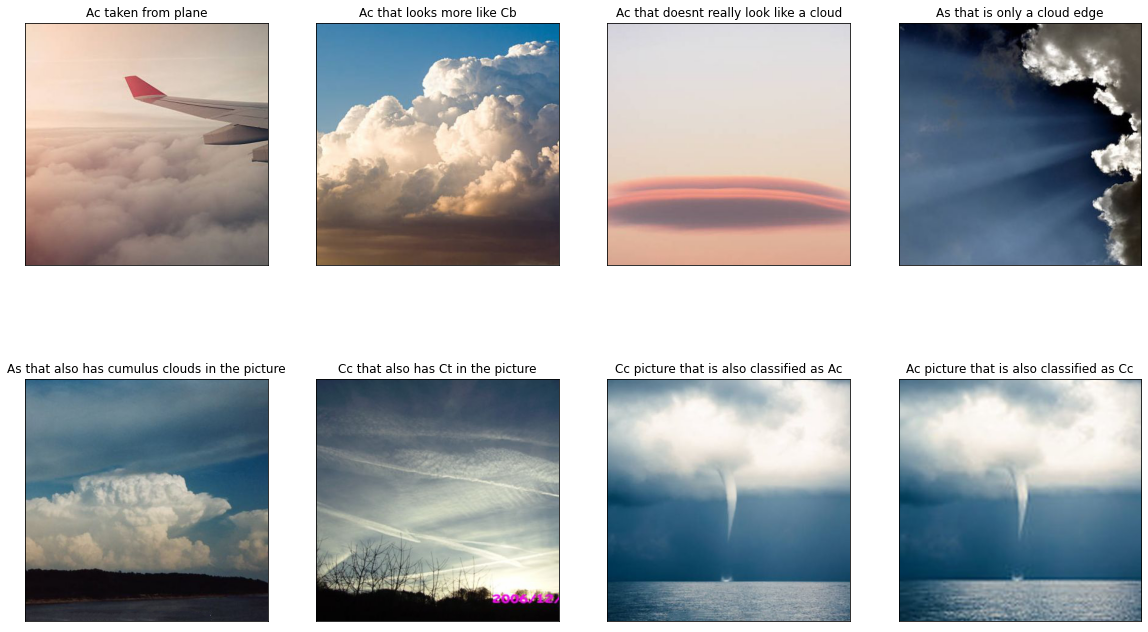

In [18]:
util.show_bad_images(data_dir)